# 🔍 Notebook 10: Model Evaluation & Interpretation

**Autor:** Gian  
**Fecha:** 2026-01-19  
**Objetivo:** Interpretar las predicciones del modelo Random Forest optimizado utilizando **SHAP (SHapley Additive exPlanations)** para entender los factores clave de retención y fuga.

---

## 📋 Contenido

1. Configuración del entorno
2. Carga de Datos y Modelo
3. Feature Importance Global (Random Forest)
4. Análisis SHAP Global (El 'Por qué')
5. Análisis de Dependencia (Relaciones No-Lineales)
6. Explicación Local (Caso Individual)
7. Conclusiones de Negocio

---
## 1. Configuración del Entorno

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import shap

# Configuración
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


---
## 2. Carga de Datos y Modelo
Cargamos el dataset procesado y el modelo `09_best_model.pkl`.

In [11]:
# Rutas
OUTPUT_PATH = Path("../../outputs/gian")
DATA_PATH = OUTPUT_PATH / "data" / "07_data_selected.csv"
MODEL_PATH = OUTPUT_PATH / "models" / "09_best_model.pkl"
FIGURES_PATH = OUTPUT_PATH / "figures"
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

# Cargar Datos
df = pd.read_csv(DATA_PATH)
X = df.drop(columns=['cancelacion', 'cliente_id'])
y = df['cancelacion']

# Cargar Modelo
model = joblib.load(MODEL_PATH)

print(f"✅ Modelo cargado: {type(model).__name__}")
print(f"📊 Dataset: {X.shape[0]} muestras")

✅ Modelo cargado: RandomForestClassifier
📊 Dataset: 9701 muestras


---
## 3. Feature Importance Global (Random Forest)
Primero miramos la importancia nativa del modelo (Gini Impurity). Esto nos dice qué variables se usaron más para dividir los árboles.

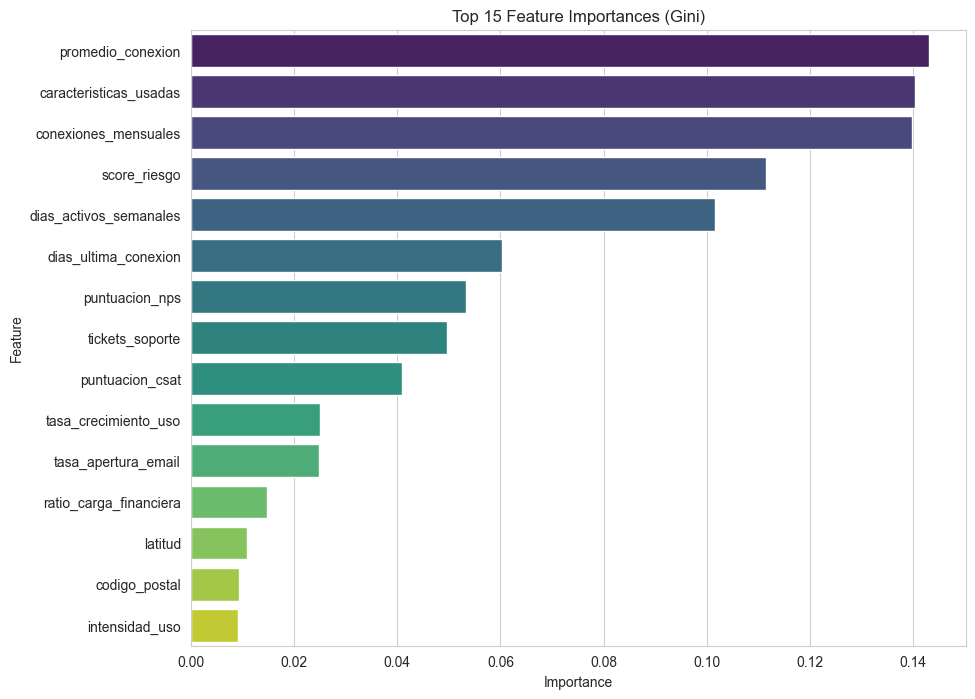

In [12]:
importances = model.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Top 15 Feature Importances (Gini)')
plt.savefig(FIGURES_PATH / "10_feature_importance_gini.png", dpi=300, bbox_inches='tight')
plt.show()

---
## 4. Análisis SHAP Global
SHAP nos dice **cómo** influye cada variable: ¿Valores altos aumentan o disminuyen el riesgo?

📊 SHAP values shape: (9701, 24)
📊 X shape: (9701, 24)


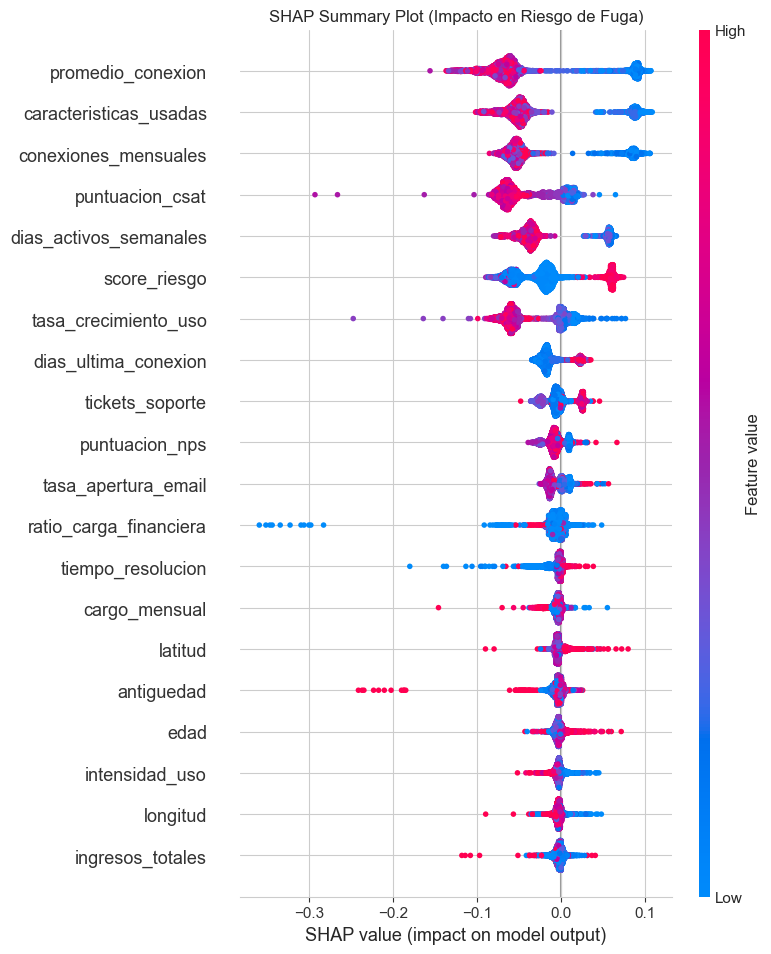

In [13]:
# Calcular SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Para clasificación binaria, shap_values es una lista [shap_class_0, shap_class_1]
# Nos interesa la clase 1 (Fuga/Churn)
if isinstance(shap_values, list):
    shap_values_churn = shap_values[1]
else:
    # En algunas versiones o configuraciones puede devolver un array
    if len(shap_values.shape) == 3:
        shap_values_churn = shap_values[:, :, 1]
    else:
        shap_values_churn = shap_values

# FIX: Verificar si hay un desajuste en las dimensiones (columna de offset constante)
if shap_values_churn.shape[1] == X.shape[1] + 1:
    print(f"⚠️ Ajustando dimensiones SHAP: {shap_values_churn.shape} -> {shap_values_churn.shape[1]-1} features (removiendo offset)")
    shap_values_churn = shap_values_churn[:, :-1]

print(f"📊 SHAP values shape: {shap_values_churn.shape}")
print(f"📊 X shape: {X.shape}")

# Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_churn, X, show=False)
plt.title('SHAP Summary Plot (Impacto en Riesgo de Fuga)')
plt.savefig(FIGURES_PATH / "10_shap_summary.png", dpi=300, bbox_inches='tight')
plt.show()

---
## 5. Análisis de Dependencia
Investigamos los Top 2 Drivers para ver su comportamiento detallado.

<Figure size 800x500 with 0 Axes>

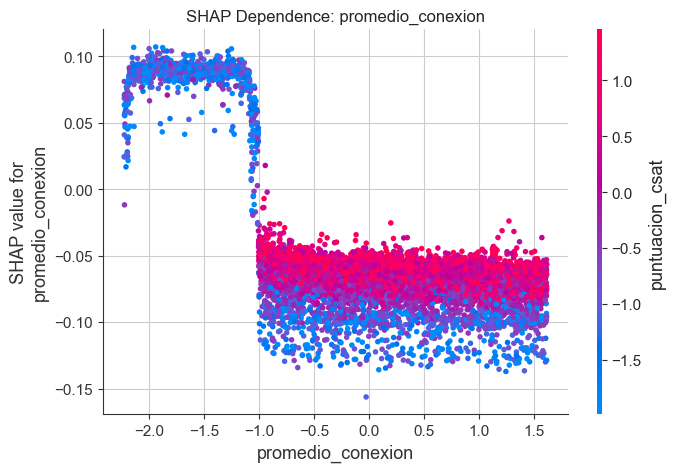

<Figure size 800x500 with 0 Axes>

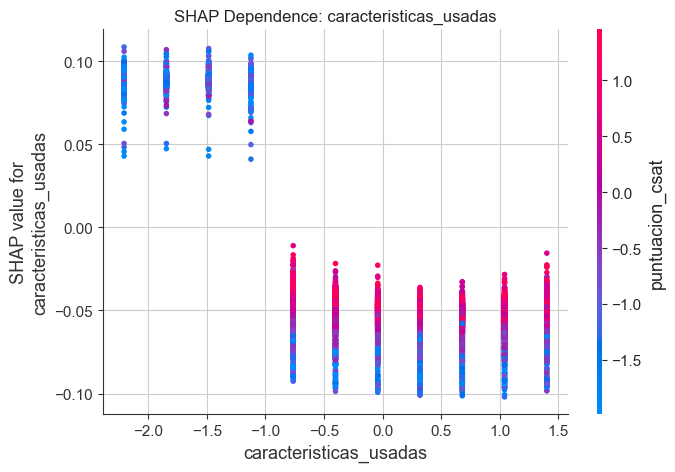

In [14]:
# Identificar top features automáticamente
top_features = feature_imp_df['Feature'].iloc[:2].values

for feat in top_features:
    plt.figure(figsize=(8, 5))
    shap.dependence_plot(feat, shap_values_churn, X, show=False)
    plt.title(f'SHAP Dependence: {feat}')
    plt.savefig(FIGURES_PATH / f"10_shap_dependence_{feat}.png", dpi=300, bbox_inches='tight')
    plt.show()

---
## 6. Explicación Local (Caso Individual)
Tomamos un cliente con ALTA probabilidad de fuga y explicamos por qué.

🔍 Analizando Cliente ID (Índice): 6042
⚠️ Probabilidad de Fuga: 0.9872


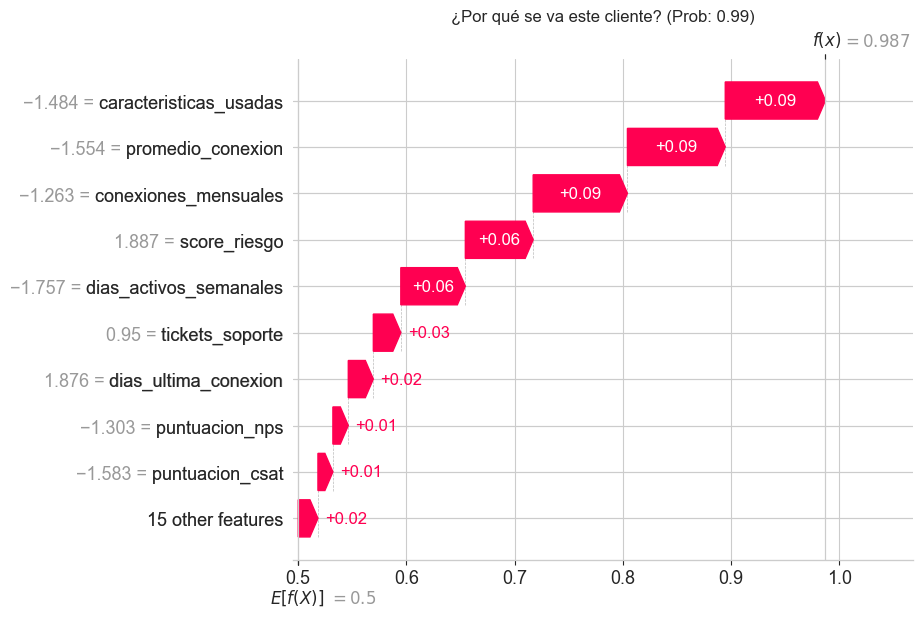

In [15]:
# Predecir probabilidades para todo el set
probs = model.predict_proba(X)[:, 1]

# Buscar el cliente con mayor probabilidad de fuga
riskiest_idx = np.argmax(probs)
customer_data = X.iloc[[riskiest_idx]]

print(f"🔍 Analizando Cliente ID (Índice): {riskiest_idx}")
print(f"⚠️ Probabilidad de Fuga: {probs[riskiest_idx]:.4f}")

# Waterfall Plot (Explicación individual)
# Nota: Para waterfall plot necesitamos un objeto Explanation a veces, 
# pero podemos construirlo manualmente si es necesario o usar expected_value.
# Si explainer.expected_value es una lista, tomamos el de la clase 1.
base_value = explainer.expected_value
if isinstance(base_value, list) or isinstance(base_value, np.ndarray):
    if len(base_value) > 1:
        base_value = base_value[1]
    else:
        base_value = base_value[0]

plt.figure(figsize=(8, 8))
shap.waterfall_plot(
    shap.Explanation(values=shap_values_churn[riskiest_idx], 
                     base_values=base_value, 
                     data=X.iloc[riskiest_idx], 
                     feature_names=X.columns),
    show=False
)
plt.title(f'¿Por qué se va este cliente? (Prob: {probs[riskiest_idx]:.2f})')
plt.savefig(FIGURES_PATH / "10_shap_individual_explanation.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 🔍 7. Conclusiones de Negocio: Top Factores de Fuga
# Analizamos los valores SHAP para extraer los insights más accionables.

print("🔍 TOP 10 FACTORES DE FUGA (Insights de Negocio):")
print("-" * 60)

# Calcular importancia absoluta media
abs_shap = np.abs(shap_values_churn).mean(axis=0)
feature_importance = pd.DataFrame(list(zip(X.columns, abs_shap)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
top_features = feature_importance.head(10)['col_name'].tolist()

for i, feature in enumerate(top_features, 1):
    # Correlación simple para ver dirección
    correlation = np.corrcoef(X[feature], shap_values_churn[:, X.columns.get_loc(feature)])[0,1]
    
    if correlation > 0:
        impact_desc = "A Mayor Valor, MAYOR Riesgo (Positivo) 📈"
        recommendation = "Reducir/Controlar este factor"
    else:
        impact_desc = "A Mayor Valor, MENOR Riesgo (Negativo) 📉"
        recommendation = "Fomentar/Aumentar este factor"
        
    n_imp = feature_importance.loc[feature_importance['col_name'] == feature, 'feature_importance_vals'].values[0]
    
    print(f"{i}. {feature}")
    print(f"   Importancia: {n_imp:.4f}")
    print(f"   Efecto: {impact_desc}")
    print(f"   Acción Sugerida: {recommendation}")
    print("-" * 60)
